In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from unidip import UniDip
from sklearn.mixture import GaussianMixture

from clusterless import preprocess
from clusterless import viz
from clusterless import decoder

In [2]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016'

In [3]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = preprocess.preprocess_static_behaviors(behave_dict)
static_behaviors = {'choice': choices, 'stimulus': one_hot_stimuli}

choices left: 0.751, right: 0.249
stimuli left: 0.547, right: 0.453
reward wrong: 0.211, correct: 0.789


In [4]:
rois = [roi.lower() for roi in ['PO', 'LP', 'DG', 'CA1', 'VIS']]

decode all regions

In [5]:
sorted_trials, good_sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=True,
    triage=False,
    good_units=True,
    thresholding=True
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)])
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]
spike_channels = unsorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

kilosort_thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    regional=False
)
print(f'kilosort thresholded neural data shape: {kilosort_thresholded_neural_data.shape}')

good_sorted = np.vstack([good_sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = good_sorted[:,0]
spike_clusters = good_sorted[:,1]

good_sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'good sorted neural data shape: {good_sorted_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
found 83 good ibl units ..
1st trial stim on time: 17.56, last trial stim on time 2310.24
sorted neural data shape: (265, 514, 30)
kilosort thresholded neural data shape: (265, 380, 30)
good sorted neural data shape: (265, 83, 30)


In [6]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

n_trials = stim_on_times.shape[0]
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    regional=False
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24
thresholded neural data shape: (265, 384, 30)


In [10]:
scales=(1, 1, 50)
log_c=5
x, z, maxptp = spike_features.T
spike_features = np.c_[x * scales[0], z * scales[1], np.log(log_c + maxptp) * scales[2]]

In [11]:
gmm_name = '../pretrained/danlab/Subjects/DY_016/post_merge_gmm'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
loaded_gmm =  GaussianMixture(n_components=len(means), covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
loaded_gmm.means_ = means
loaded_gmm.covariances_ = covar

spike_labels = []
spike_probs = []
offset = 100_000
for i in range(8):
    print(f'loading batch {i+1} ..')
    spike_labels.extend(loaded_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    spike_probs.extend(loaded_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30,
    regional=False
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

loading batch 1 ..
loading batch 2 ..
loading batch 3 ..
loading batch 4 ..
loading batch 5 ..
loading batch 6 ..
loading batch 7 ..
loading batch 8 ..
clusterless neural data shape: (265, 409, 30)


In [12]:
neural_data_dict = {
    'good units': good_sorted_neural_data,
    'sorted': sorted_neural_data,
    'kilosort thresholded': kilosort_thresholded_neural_data,
    'thresholded': thresholded_neural_data,
    'clusterless': clusterless_neural_data
} 

all_n_units_dict = {
        'good units': good_sorted_neural_data.shape[1],
        'sorted': sorted_neural_data.shape[1],
        'kilosort thresholded': kilosort_thresholded_neural_data.shape[1],
        'thresholded': thresholded_neural_data.shape[1],
        'clusterless': clusterless_neural_data.shape[1]
}

In [13]:
all_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in all_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type}:')
        decode_results = decoder.cv_decode_static(
            neural_data_dict[data_type], 
            static_behaviors[behave_type], 
            behave_type=behave_type, 
            n_folds=5, 
            seed=seed, 
            shuffle=True)
        all_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{save_path}/static_behaviors/all_decode_results.npy', all_decode_results)

good units:
choice fold 1 test accuracy: 0.887 auc: 0.950
choice fold 2 test accuracy: 0.887 auc: 0.952
choice fold 3 test accuracy: 0.887 auc: 0.898
choice fold 4 test accuracy: 0.925 auc: 0.996
choice fold 5 test accuracy: 0.868 auc: 0.905
choice mean of 5-fold cv accuracy: 0.891 auc: 0.940
choice sd of 5-fold cv accuracy: 0.018 auc: 0.036
sorted:
choice fold 1 test accuracy: 0.868 auc: 0.912
choice fold 2 test accuracy: 0.906 auc: 0.967
choice fold 3 test accuracy: 0.906 auc: 0.967
choice fold 4 test accuracy: 0.925 auc: 0.981
choice fold 5 test accuracy: 0.906 auc: 0.954
choice mean of 5-fold cv accuracy: 0.902 auc: 0.956
choice sd of 5-fold cv accuracy: 0.018 auc: 0.024
kilosort thresholded:
choice fold 1 test accuracy: 0.849 auc: 0.887
choice fold 2 test accuracy: 0.887 auc: 0.977
choice fold 3 test accuracy: 0.925 auc: 0.973
choice fold 4 test accuracy: 0.943 auc: 0.973
choice fold 5 test accuracy: 0.868 auc: 0.941
choice mean of 5-fold cv accuracy: 0.894 auc: 0.950
choice sd of

decode brain regions

In [42]:
roi = rois[4]
print(roi)

vis


In [43]:
sorted_trials, good_sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi=roi,
    kilosort=True,
    triage=False,
    good_units=True,
    thresholding=True
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)])
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]
spike_channels = unsorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=True
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

kilosort_thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    regional=True
)
print(f'kilosort thresholded neural data shape: {kilosort_thresholded_neural_data.shape}')

good_sorted = np.vstack([good_sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = good_sorted[:,0]
spike_clusters = good_sorted[:,1]

good_sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=True
)
print(f'good sorted neural data shape: {good_sorted_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
found 83 good ibl units ..
1st trial stim on time: 17.56, last trial stim on time 2310.24
found 29 neurons in region vis ...
found 28 channels in region vis ...
sorted neural data shape: (265, 29, 30)
kilosort thresholded neural data shape: (265, 15, 30)
good sorted neural data shape: (265, 6, 30)


In [44]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi=roi,
    kilosort=False,
    triage=False
)

n_trials = stim_on_times.shape[0]
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times_unsorted = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times_unsorted, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    regional=True
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24
found 29 neurons in region vis ...
found 28 channels in region vis ...
thresholded neural data shape: (265, 27, 30)


In [45]:
scales=(1, 1, 50)
log_c=5
x, z, maxptp = spike_features.T
spike_features = np.c_[x * scales[0], z * scales[1], np.log(log_c + maxptp) * scales[2]]

In [46]:
gmm_name = '../pretrained/danlab/Subjects/DY_016/post_merge_gmm'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
loaded_gmm = GaussianMixture(n_components=len(means), covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
loaded_gmm.means_ = means
loaded_gmm.covariances_ = covar

spike_labels = loaded_gmm.predict(spike_features)
spike_probs = loaded_gmm.predict_proba(spike_features)

clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times_unsorted, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30,
    regional=True
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (265, 30, 30)


In [47]:
neural_data_dict = {
        'good units': good_sorted_neural_data,
        'sorted': sorted_neural_data,
        'kilosort thresholded': kilosort_thresholded_neural_data,
        'thresholded': thresholded_neural_data,
        'clusterless': clusterless_neural_data
} 

# regional_n_units_dict = {
#         'good units': good_sorted_neural_data.shape[1],
#         'sorted': sorted_neural_data.shape[1],
#         'kilosort thresholded': kilosort_thresholded_neural_data.shape[1],
#         'thresholded': thresholded_neural_data.shape[1],
#         'clusterless': clusterless_neural_data.shape[1]
# }

In [48]:
regional_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in regional_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type}:')
        decode_results = decoder.cv_decode_static(
            neural_data_dict[data_type], 
            static_behaviors[behave_type], 
            behave_type=behave_type, 
            n_folds=5, 
            seed=seed, 
            shuffle=True)
        regional_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{save_path}/static_behaviors/{roi}_decode_results.npy', regional_decode_results)
# np.save(f'{save_path}/static_behaviors/{roi}_n_units_dict.npy', regional_n_units_dict)

good units:
choice fold 1 test accuracy: 0.660 auc: 0.588
choice fold 2 test accuracy: 0.660 auc: 0.556
choice fold 3 test accuracy: 0.660 auc: 0.638
choice fold 4 test accuracy: 0.660 auc: 0.612
choice fold 5 test accuracy: 0.736 auc: 0.703
choice mean of 5-fold cv accuracy: 0.675 auc: 0.620
choice sd of 5-fold cv accuracy: 0.030 auc: 0.050
sorted:
choice fold 1 test accuracy: 0.679 auc: 0.700
choice fold 2 test accuracy: 0.736 auc: 0.633
choice fold 3 test accuracy: 0.774 auc: 0.575
choice fold 4 test accuracy: 0.717 auc: 0.688
choice fold 5 test accuracy: 0.755 auc: 0.645
choice mean of 5-fold cv accuracy: 0.732 auc: 0.648
choice sd of 5-fold cv accuracy: 0.032 auc: 0.045
kilosort thresholded:
choice fold 1 test accuracy: 0.755 auc: 0.754
choice fold 2 test accuracy: 0.642 auc: 0.556
choice fold 3 test accuracy: 0.623 auc: 0.602
choice fold 4 test accuracy: 0.642 auc: 0.496
choice fold 5 test accuracy: 0.585 auc: 0.634
choice mean of 5-fold cv accuracy: 0.649 auc: 0.608
choice sd of

decode choice

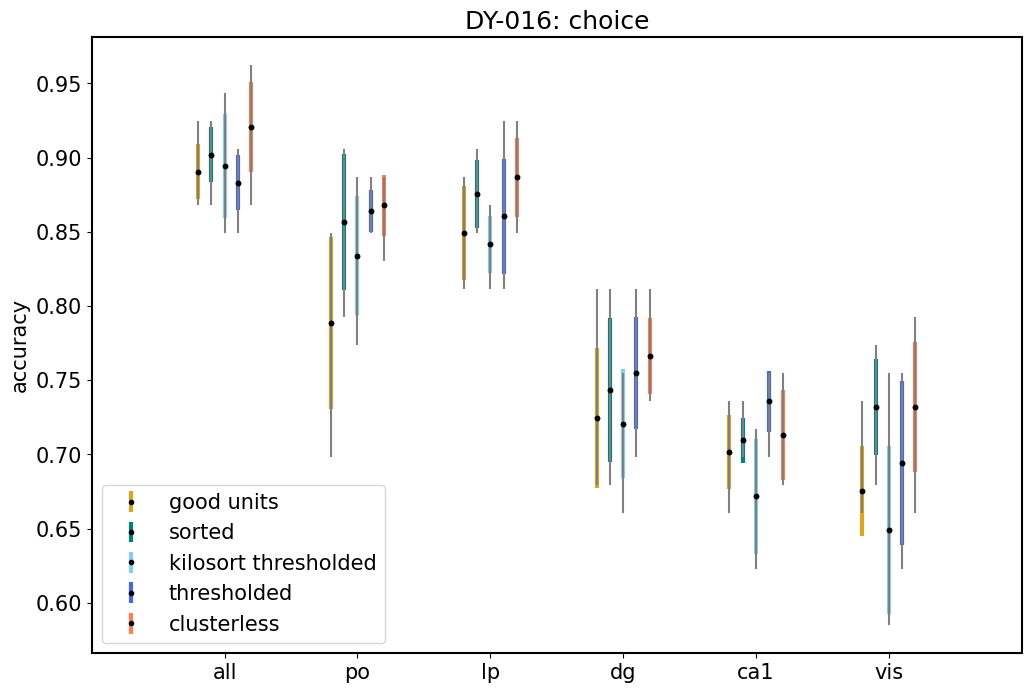

In [50]:
viz.plot_compare_decoder_barplots(
    save_path + '/static_behaviors',
    behave_type='choice', 
    metric_type='accuracy', 
    rois=rois, 
    n_folds=5, 
    add_smooth=False, 
    figure_size=(12,8), 
    font_size=15, 
    title='DY-016: choice',
    save_fig=True,
    fig_path='../saved_figs/danlab/Subjects/DY_016',
)

decode stimulus

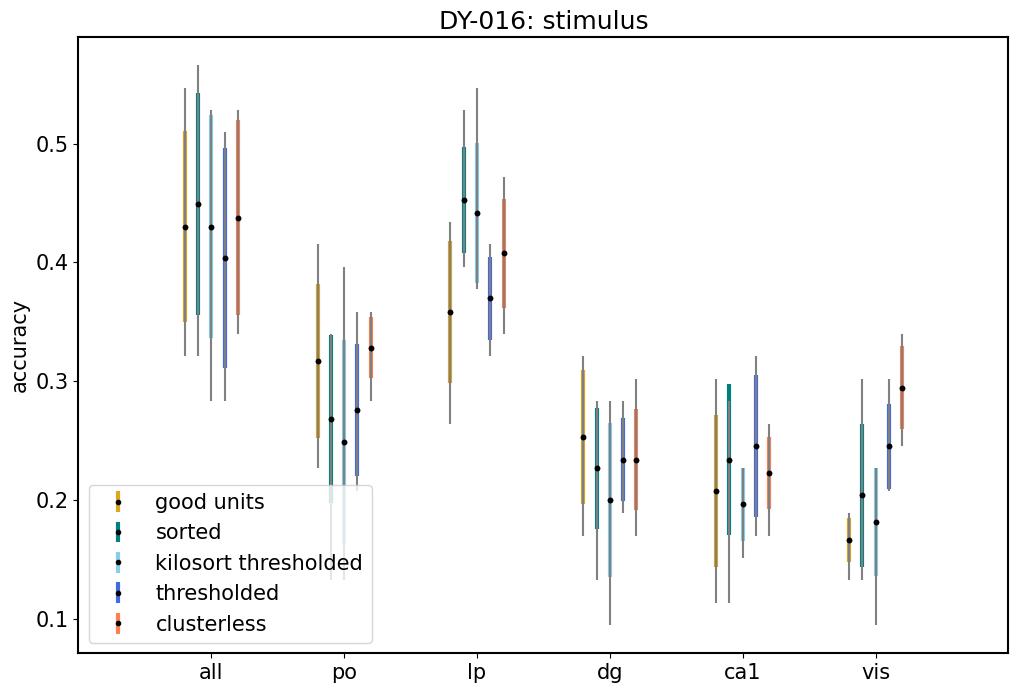

In [58]:
viz.plot_compare_decoder_barplots(
    save_path + '/static_behaviors',
    behave_type='stimulus', 
    metric_type='accuracy', 
    rois=rois, 
    n_folds=5, 
    add_smooth=False, 
    figure_size=(12,8), 
    font_size=15, 
    title='DY-016: stimulus',
    save_fig=True,
    fig_path='../saved_figs/danlab/Subjects/DY_016',
)